# COVID-19 Auswertung - new cases, deaths, Intensivstationen
## DIVI und WHO Daten - Deutschland und einige Nachbarn


## import libraries

In [1]:
import pandas as pd #Daten
from matplotlib import pyplot as plt # plots
#import matplotlib as mpl
from matplotlib.ticker import FuncFormatter   # Numberformat plot ticks
import numpy as np

# performance
from datetime import datetime
from datetime import date # todays date
import seaborn as sns

import os
now = datetime.now()

# Preprocessing Dataframes

## Datenimport

In [2]:
# Webabruf - CSV einlesen
data = pd.read_csv("https://covid19.who.int/WHO-COVID-19-global-data.csv")

# Lokal - CSV einlesen
#df = pd.read_csv("D:\Github\Covid-19-Auswertung-WHO-DIVI\data-WvhXR.csv")

# Lokal - CSV einlesen
df_divi2 = pd.read_csv("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\data-k3LbD.csv")
df_divi2['date'] = pd.to_datetime(df_divi2.date, utc=True)
#df_divi2 = df.loc[df.date >= ts, :]

# Lokal CSV einlesen - Testzahlen
df_PQ = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Testzahlen-gesamt.xlsx",
                    sheet_name ="Testzahlen",
                    usecols="B:F",
                    skiprows=2,)

# df_I = pd.read_excel("D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\Impfquotenmonitoring.xlsx",
#                     sheet_name =[1],
#                     usecols="A:G",
#                     skiprows=0,)

# df_I

In [3]:
#df_PQ

### preprocessing

In [4]:
#gleitender Mittelwert der cases und deaths, 7 Tage
data['MA'] = data['New_cases'].rolling(window=7,min_periods=1).mean()
data['MA_deaths'] = data['New_deaths'].rolling(window=7, min_periods=1).mean()

data['MSTD_cases'] = data['New_cases'].rolling(window=7,min_periods=1).std()
data['MSTD_deaths'] = data['New_deaths'].rolling(window=7,min_periods=1).std()

data['OTG_cases'] = data['MA'] + data['MSTD_cases']
data['UTG_cases'] = data['MA'] - data['MSTD_cases']

data['OTG_deaths'] = data['MA_deaths'] + data['MSTD_deaths']
data['UTG_deaths'] = data['MA_deaths'] - data['MSTD_deaths']

# Date_reported in eine Datumsspalte umwandeln
data['Date_reported'] = pd.to_datetime(data.Date_reported, utc=True)

# df['date'] = pd.to_datetime(df.date, utc=True)

#Timestamp definieren  YYYY-MM-DD
ts = pd.to_datetime('2020-10-01', utc=True)

#dataframe reduzieren 
data = data.loc[data.Date_reported >= ts, :]
df_divi2 = df_divi2.loc[df_divi2.date >= ts, :]
# df = df.loc[df.date >= ts, :]

# preprocessing Positivenquote
df_PQ = df_PQ.replace('\*','',regex=True)
df_PQ.drop(df_PQ.tail(2).index,inplace=True) # drop last n rows
df_PQ.drop(df_PQ.head(1).index,inplace=True) # drop last n rows
df_PQ["Positiven-quote (%)"] = df_PQ["Positiven-quote (%)"].astype(float).round(1)
#df_PQ["Positiven-quote (%)"] = df_PQ["Positiven-quote (%)"].astype(str)+ " %"
df_PQ["Kalenderwoche 2020"] = "KW "+df_PQ["Kalenderwoche 2020"].astype(str)

In [5]:
df_PQ

,Kalenderwoche 2020,Anzahl Testungen,Positiv getestet,Positiven-quote (%),Anzahl übermittelnde Labore
1,KW 11,127457.0,7582.0,5.9,114.0
2,KW 12,348619.0,23820.0,6.8,152.0
3,KW 13,361515.0,31414.0,8.7,151.0
4,KW 14,408348.0,36885.0,9.0,154.0
5,KW 15,380197.0,30791.0,8.1,164.0
6,KW 16,331902.0,22082.0,6.7,168.0
7,KW 17,363890.0,18083.0,5.0,178.0
8,KW 18,326788.0,12608.0,3.9,175.0
9,KW 19,403875.0,10755.0,2.7,182.0
10,KW 20,432076.0,7080.0,1.6,185.0


### Länder definieren

In [6]:
ger = data[data.Country == 'Germany']
fr = data[data.Country == 'France']
at = data[data.Country == 'Austria']
pl = data[data.Country == 'Poland']
cz = data[data.Country == 'Czechia']
ch = data[data.Country == 'Switzerland']
it = data[data.Country == 'Italy']
es = data[data.Country == 'Spain']
gb = data[data.Country == 'The United Kingdom']
se = data[data.Country == 'Sweden']

#euro = data[data.WHO_region == 'EURO']

# Variablen für die Plots definieren

### Linien und Schriftgrößen

In [7]:
# Linien Stärke
lws = 3
lwb = 7
# Bezugsschriftgröße
size = 28

### Einwohnerzahlen

In [8]:
E_fr = 66012908
E_pl = 38659927
E_ger = 81504947
E_cz = 10586651
E_at = 8902600
E_ch = 8847020
E_gb = 66650000

 ### Bezugsgröße Einwohner und Datum

In [9]:
pE = 100000

# Heutiges Datum und formatieren dd.mm.YYYY
today = date.today().strftime("%d.%m.%Y")

### Speicherorte und Dateinamen

In [10]:
pfad = "D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\"

name_1_1 = "plot_1-1_cases_absolute numbers.png" # cases absoulte zahlen EU
name_1_2 = "plot_1-2_cases.png" # cases pro 100.000 Einwohner EU 
name_2 = "plot_2_intensiv.png" # intensiv Deutschland
name_2_2 = "plot_2_2_intensiv2.png" # intensiv Deutschland
name_3_1 = "plot_3-1_deaths_absolute numbers.png" # deaths absolute zahlen EU
name_3_2 = "plot_3-2_deaths.png" # deaths pro 100.000 Einwohner EU
name_4_1 = "plot_4-1_cases_ger.png" # cases Deutschland
name_4_2 = "plot_4-2_deaths_ger.png" # deaths Deutschland
name_5 = "performance_dist_plot.png" # Performance Plot
name_6 = "plot_6_Positivenquote.png" # Positivenquote
name_6_2 = "plot_6-2_Anzahl_Testungen.png" # Positivenquote

## Länder Farben

In [11]:
c_fr = '#f80d0d'    # rot
c_pl = '#25e5e5'    # cyan
c_ger = '#0721ff'   # dunkelblau
c_cz = '#bb8fce'    # lila
c_at = '#18c213'    # grün
c_ch = '#000000'    # schwarz
c_gb = '#faac2b'    # orange

# Visualisierung der Plots

### 1-1) Neue Fälle 7 Tage Mittelwert (absolute Zahlen)

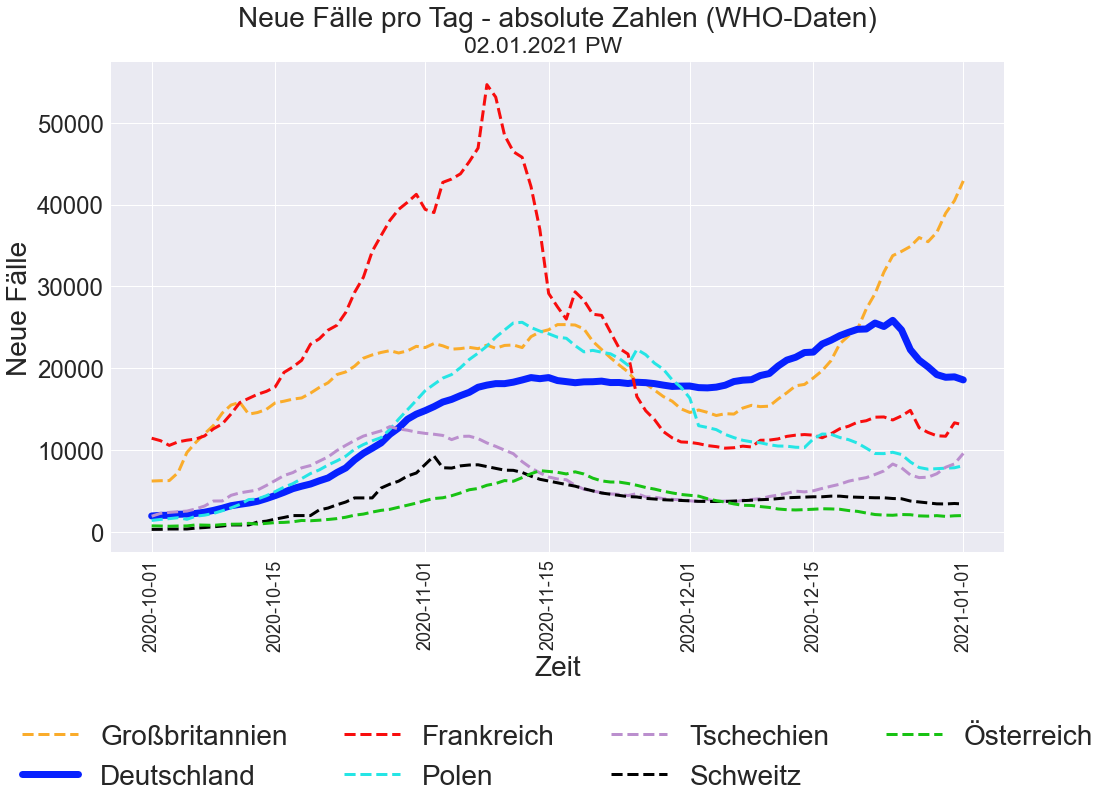

In [12]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')

# Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 

plt.plot(gb.Date_reported,gb['MA'], color=c_gb, linestyle = 'dashed', linewidth = lws, label="Großbritannien")
plt.plot(ger.Date_reported,ger['MA'], color=c_ger, linestyle = 'solid', linewidth = lwb, label="Deutschland")
plt.plot(fr.Date_reported,fr['MA'], color=c_fr, linestyle = 'dashed', linewidth = lws, label="Frankreich")
plt.plot(pl.Date_reported,pl['MA'], color=c_pl, linestyle = 'dashed', linewidth = lws, label="Polen")
plt.plot(cz.Date_reported,cz['MA'], color=c_cz, linestyle = 'dashed', linewidth = lws, label="Tschechien")
plt.plot(ch.Date_reported,ch['MA'], color=c_ch, linestyle = 'dashed', linewidth = lws, label="Schweitz")
plt.plot(at.Date_reported,at['MA'], color=c_at, linestyle = 'dashed', linewidth = lws, label="Österreich")

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Neue Fälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Neue Fälle pro Tag - absolute Zahlen (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_1_1, dpi = 150, bbox_inches='tight')
#plt.close()

### 1-2) Neue Fälle 7 Tage Mittelwert (pro 100.000 Einwohner)

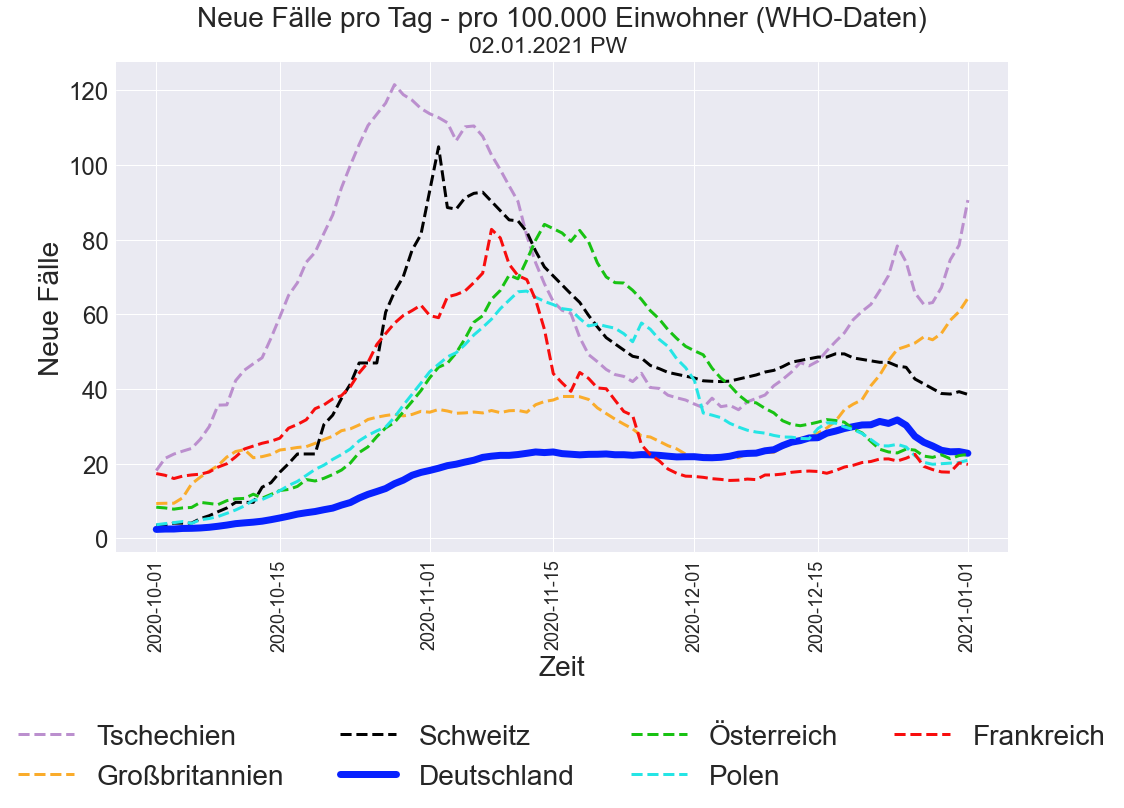

In [13]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')


# Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 

plt.plot(cz.Date_reported,cz['MA']* (pE/E_cz), color=c_cz, linestyle = 'dashed', linewidth = lws, label="Tschechien")
plt.plot(gb.Date_reported,gb['MA']* (pE/E_gb), color=c_gb, linestyle = 'dashed', linewidth = lws, label="Großbritannien")
plt.plot(ch.Date_reported,ch['MA']* (pE/E_ch), color=c_ch, linestyle = 'dashed', linewidth = lws, label="Schweitz")
plt.plot(ger.Date_reported,ger['MA']* (pE/E_ger), color=c_ger, linestyle = 'solid', linewidth = lwb, label="Deutschland")
plt.plot(at.Date_reported,at['MA']* (pE/E_at), color=c_at, linestyle = 'dashed', linewidth = lws, label="Österreich")
plt.plot(pl.Date_reported,pl['MA']* (pE/E_pl), color=c_pl, linestyle = 'dashed', linewidth = lws, label="Polen")
plt.plot(fr.Date_reported,fr['MA']* (pE/E_fr), color=c_fr, linestyle = 'dashed', linewidth = lws, label="Frankreich")

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)


# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Neue Fälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Neue Fälle pro Tag - pro 100.000 Einwohner (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_1_2, dpi = 150, bbox_inches='tight')
# plt.close()

### 2-2) Intensivstationen DIVI2

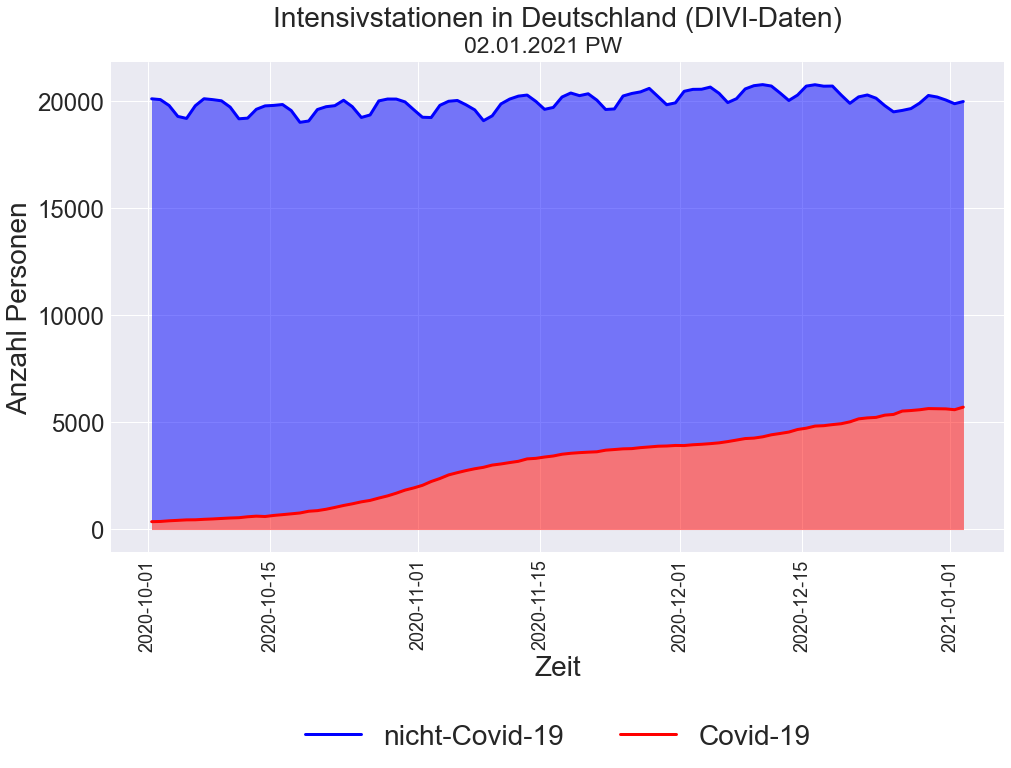

In [14]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)
plt.plot(df_divi2.date,df_divi2['Belegte Betten'], color = 'blue', linewidth = lws, label = "nicht-Covid-19")
plt.plot(df_divi2.date,df_divi2['COVID-19-Fälle'], color = 'red', linewidth = lws, label = "Covid-19")


plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=2, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)

# plt.xticks([])
plt.ylabel('Anzahl Personen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)
#plt.title('DIVI-Intensivregister (www.intensivregister.de)  \n Stand: ' + today, fontsize=size)

plt.title('Intensivstationen in Deutschland (DIVI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between 
plt.fill_between(df_divi2.date, df_divi2['COVID-19-Fälle'], color='red',alpha=0.5)
plt.fill_between(df_divi2.date, df_divi2['COVID-19-Fälle'], df_divi2['Belegte Betten'], color='blue',alpha=0.5)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_2_2, dpi = 150, bbox_inches='tight')
plt.show()
plt.close()

###  3-1) Todesfälle 7 Tage Mittelwert (absolute Zahlen) 

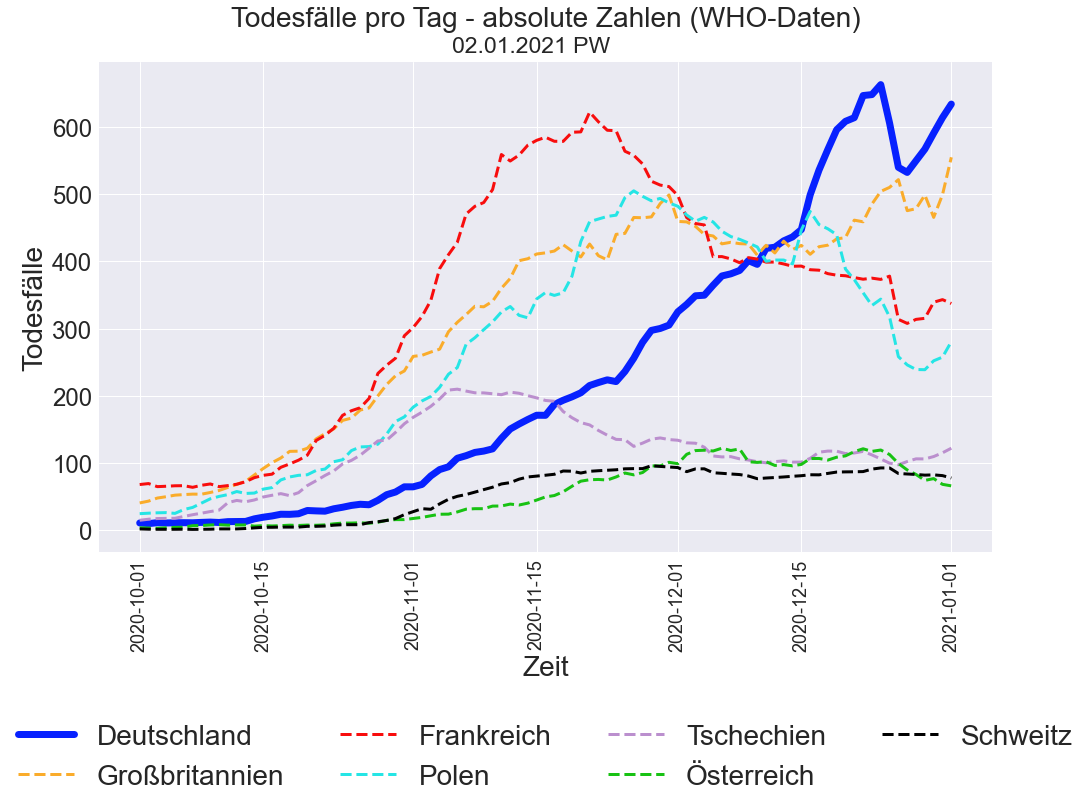

In [15]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)

# Todesfälle pro 100.000 Einwohner 02.12.2020
plt.plot(ger.Date_reported,ger['MA_deaths'], color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland") # blau, linie, dick
plt.plot(gb.Date_reported,gb['MA_deaths'], color=c_gb, linestyle = 'dashed', linewidth = lws, label = "Großbritannien") # gelb, gestrichelt, dünn
plt.plot(fr.Date_reported,fr['MA_deaths'], color=c_fr, linestyle = 'dashed', linewidth = lws, label = "Frankreich") # rot, gestrichelt, dünn
plt.plot(pl.Date_reported,pl['MA_deaths'], color=c_pl, linestyle = 'dashed', linewidth = lws, label = "Polen") # cyan, gestrichelt, dünn
plt.plot(cz.Date_reported,cz['MA_deaths'], color=c_cz, linestyle = 'dashed', linewidth = lws, label = "Tschechien") # magenta, gestrichelt, dünn
plt.plot(at.Date_reported,at['MA_deaths'], color=c_at, linestyle = 'dashed', linewidth = lws, label = "Österreich") # grün, gestrichelt, dünn
plt.plot(ch.Date_reported,ch['MA_deaths'], color=c_ch, linestyle = 'dashed', linewidth = lws, label = "Schweitz") # schwarz, gestrichelt, dünn

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)
plt.ylabel('Todesfälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Todesfälle pro Tag - absolute Zahlen (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)


# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_3_1, dpi = 150, bbox_inches='tight')
# plt.close()

###  3-2) Todesfälle 7 Tage Mittelwert (pro 100.000 Einwohner) 

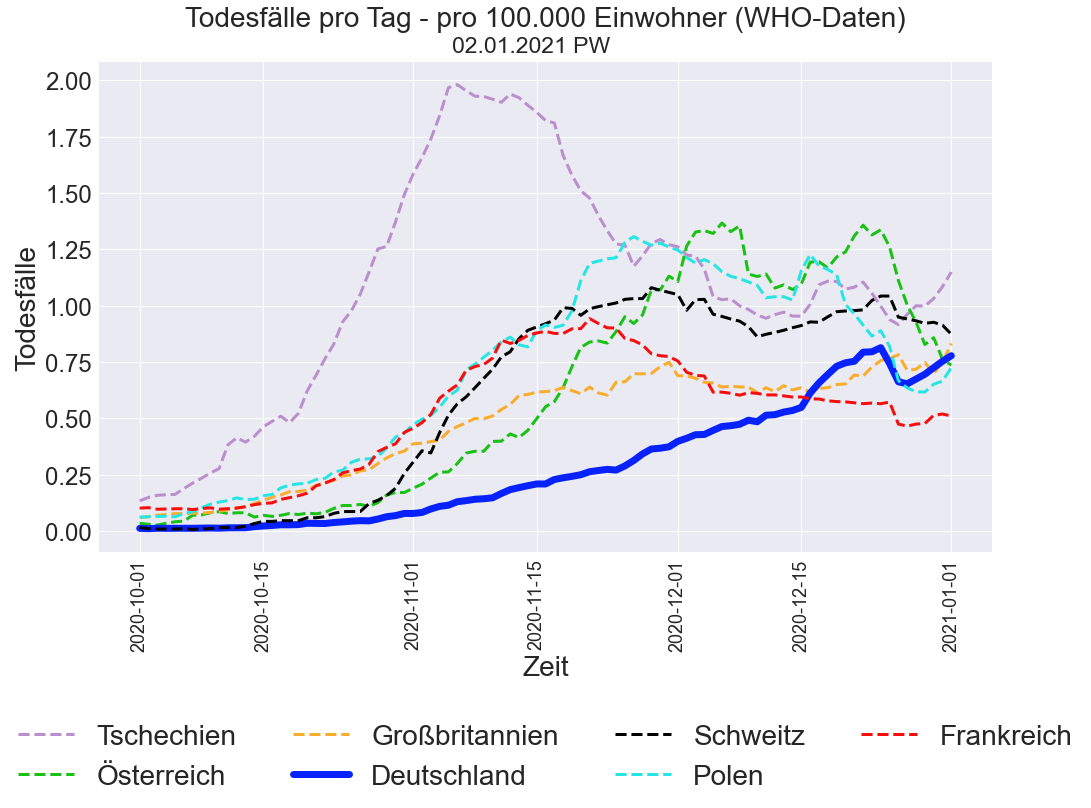

In [16]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)

# Todesfälle pro 100.000 Einwohner 02.12.2020

plt.plot(cz.Date_reported,cz['MA_deaths'] * (pE/E_cz), color=c_cz, linestyle = 'dashed', linewidth = lws, label = "Tschechien") # magenta, gestrichelt, dünn
plt.plot(at.Date_reported,at['MA_deaths'] * (pE/E_at), color=c_at, linestyle = 'dashed', linewidth = lws, label = "Österreich") # grün, gestrichelt, dünn
plt.plot(gb.Date_reported,gb['MA_deaths'] * (pE/E_gb), color=c_gb, linestyle = 'dashed', linewidth = lws, label = "Großbritannien") # gelb, gestrichelt, dünn
plt.plot(ger.Date_reported,ger['MA_deaths'] * (pE/E_ger), color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland") # blau, linie, dick
plt.plot(ch.Date_reported,ch['MA_deaths'] * (pE/E_ch), color=c_ch, linestyle = 'dashed', linewidth = lws, label = "Schweitz") # schwarz, gestrichelt, dünn
plt.plot(pl.Date_reported,pl['MA_deaths'] * (pE/E_pl), color=c_pl, linestyle = 'dashed', linewidth = lws, label = "Polen") # cyan, gestrichelt, dünn
plt.plot(fr.Date_reported,fr['MA_deaths'] * (pE/E_fr), color=c_fr, linestyle = 'dashed', linewidth = lws, label = "Frankreich") # rot, gestrichelt, dünn


# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=4, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)
plt.ylabel('Todesfälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Todesfälle pro Tag - pro 100.000 Einwohner (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_3_2, dpi = 150, bbox_inches='tight')
#plt.close()

In [17]:
# ts = pd.to_datetime('2020-12-15', utc=True)
# #dataframe reduzieren 
# data = data.loc[data.Date_reported >= ts, :]
# ger = data[data.Country == 'Germany']

###  4-1) Cases 7 Tage Mittelwert Deutschland

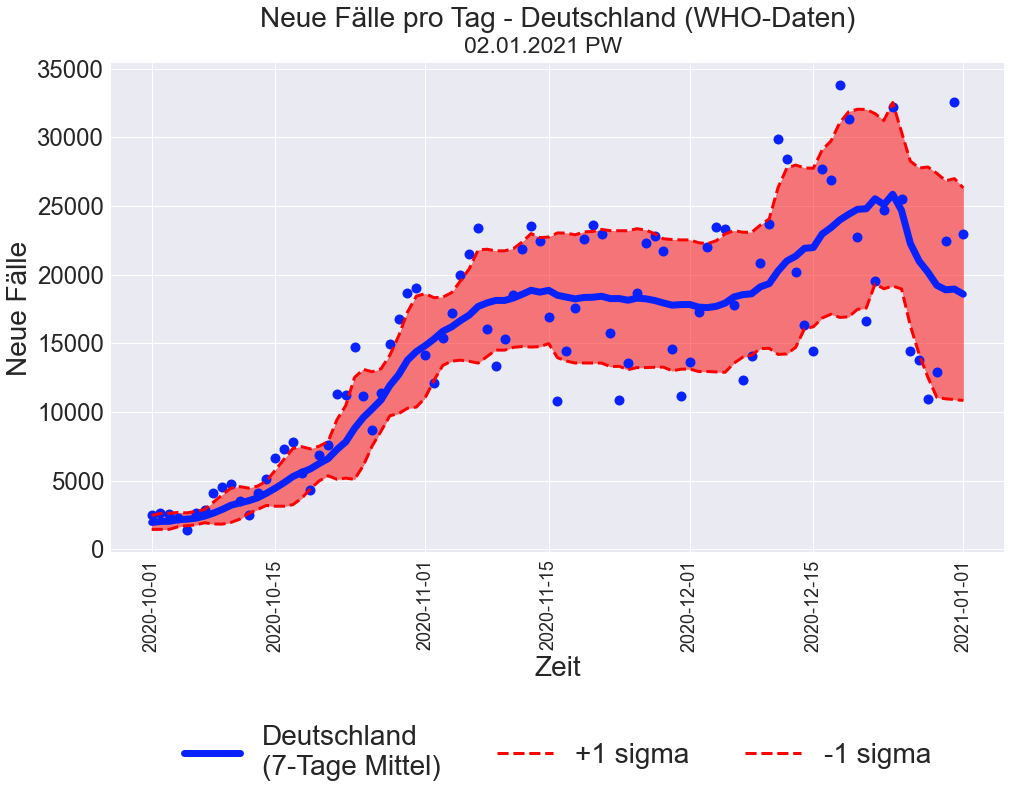

In [18]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

# Neue Fälle pro Tag pro 100.000 Einwohner - 02.12.2020 
plt.plot(ger.Date_reported,ger['MA'], color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland\n(7-Tage Mittel)")
plt.plot(ger.Date_reported,ger['New_cases'], marker='.', linestyle='', color=c_ger, markersize = 20)
plt.plot(ger.Date_reported,ger['OTG_cases'], color='red', linestyle = 'dashed', linewidth = lws, label ="+1 sigma")
plt.plot(ger.Date_reported,ger['UTG_cases'], color='red', linestyle = 'dashed', linewidth = lws, label ="-1 sigma")

plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=3, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)

plt.ylabel('Neue Fälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Neue Fälle pro Tag - Deutschland (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between lines
plt.fill_between(ger.Date_reported, ger['OTG_cases'], ger['UTG_cases'] , color='red',alpha=0.5)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_4_1, dpi = 150, bbox_inches='tight')
#plt.close()

###  4-2) Deaths 7 Tage Mittelwert Deutschland

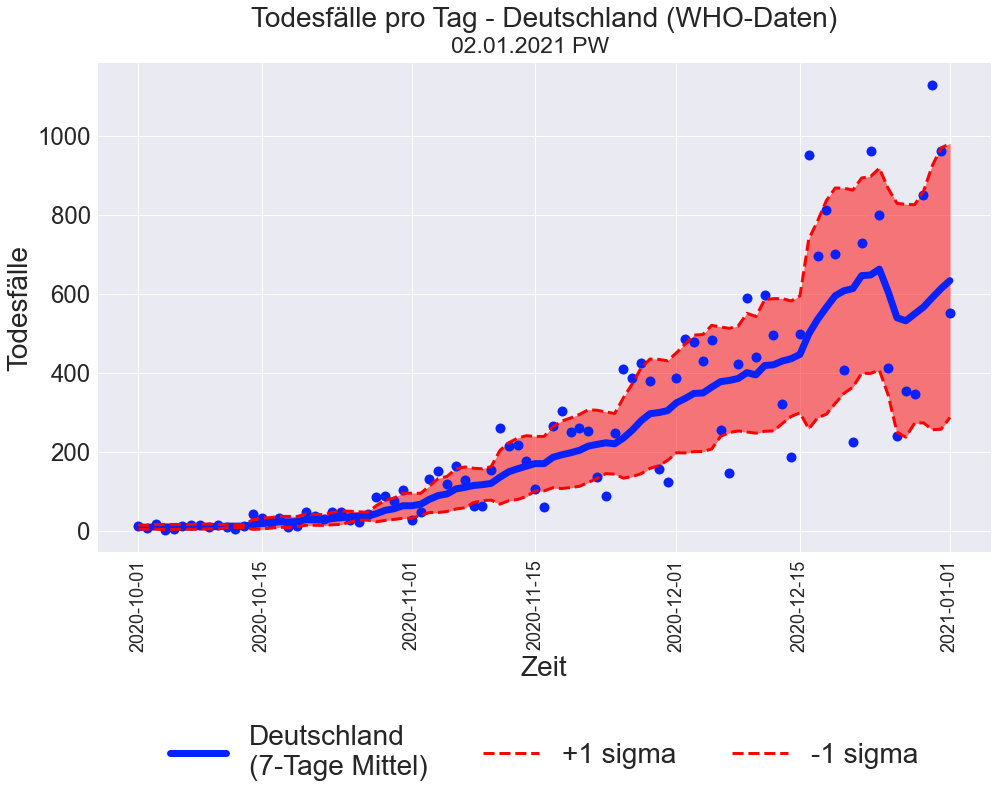

In [19]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')
plt.grid(True)

# Todesfälle pro 100.000 Einwohner 02.12.2020

plt.plot(ger.Date_reported,ger['MA_deaths'], color=c_ger, linestyle = 'solid', linewidth = lwb, label = "Deutschland\n(7-Tage Mittel)") # blau, linie, dick
plt.plot(ger.Date_reported,ger['New_deaths'], marker='.', linestyle='', color=c_ger, markersize = 20)

plt.plot(ger.Date_reported,ger['OTG_deaths'], color='red', linestyle = 'dashed', linewidth = lws, label ="+1 sigma")
plt.plot(ger.Date_reported,ger['UTG_deaths'], color='red', linestyle = 'dashed', linewidth = lws, label ="-1 sigma")

# Legende 
plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5, -0.3),
           fancybox=True, 
           shadow=True, 
           ncol=3, 
           fontsize=size)

# Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 10, rotation = 90)
plt.yticks(fontsize=size -4)
plt.ylabel('Todesfälle', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Todesfälle pro Tag - Deutschland (WHO-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# fill area between lines
plt.fill_between(ger.Date_reported, ger['OTG_deaths'], ger['UTG_deaths'] , color='red',alpha=0.5)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_4_2, dpi = 150, bbox_inches='tight')
#plt.close()

## RKI Positivenquote pro Woche

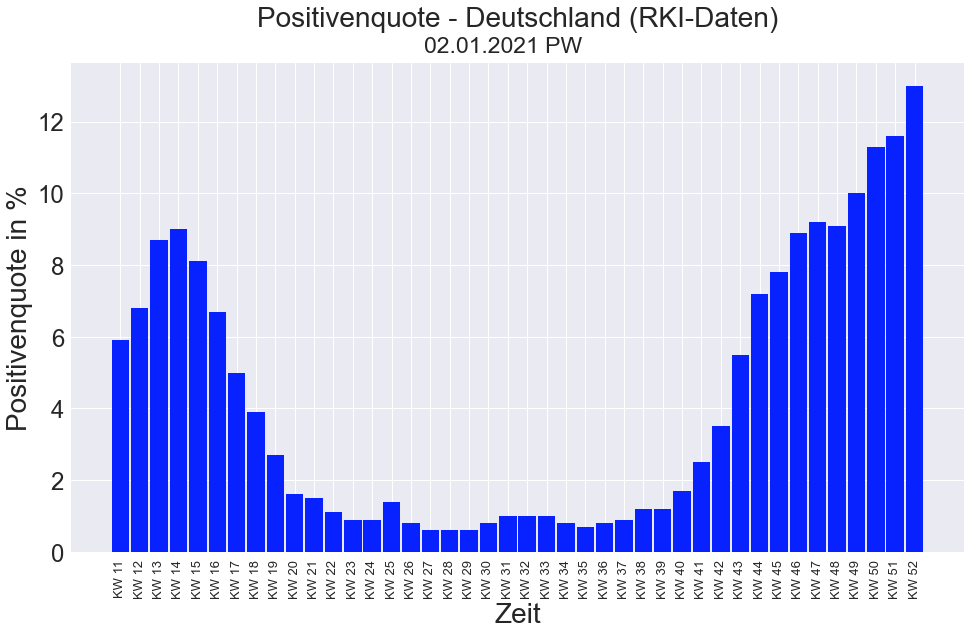

In [20]:
# Größe im 16:9 format und mit Umrechnungsfaktor 1.2 (durch Test ermittelt) für PowerPoint angepasst
plt.figure(figsize=(16,9))

plt.style.use('seaborn')

plt.bar(x=df_PQ["Kalenderwoche 2020"], height=df_PQ["Positiven-quote (%)"], width = 0.9, align = 'center', color = c_ger)

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 15, rotation=90)
plt.yticks(fontsize=size -4)

plt.ylabel('Positivenquote in %', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Positivenquote - Deutschland (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

# Diagramm als Bild exporieren und Auflösung definieren
plt.savefig(pfad + name_6, dpi = 150, bbox_inches='tight')
#plt.close()


In [21]:
df_PQ.head(1)

,Kalenderwoche 2020,Anzahl Testungen,Positiv getestet,Positiven-quote (%),Anzahl übermittelnde Labore
1,KW 11,127457.0,7582.0,5.9,114.0


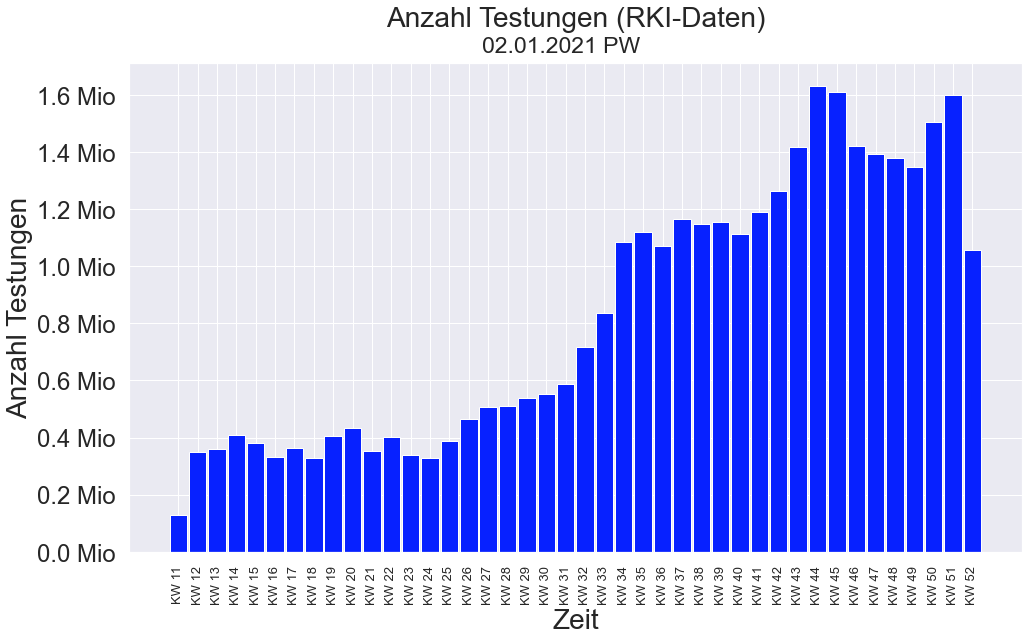

In [34]:
def millions(x, pos):
   # 'The two args are the value and tick position'
    return '%1.1f Mio' % (x * 1e-6)
formatter = FuncFormatter(millions)


fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
ax.yaxis.set_major_formatter(formatter)


ax = plt.bar(x=df_PQ["Kalenderwoche 2020"], height=df_PQ["Anzahl Testungen"], width = 0.9, align = 'center', color = c_ger)

# # Schriftgrößen x und y achsenwerte
plt.xticks(fontsize=size - 15, rotation=90)
plt.yticks(fontsize=size -4)


plt.ylabel('Anzahl Testungen', fontsize=size)
plt.xlabel('Zeit', fontsize=size)

plt.title('Anzahl Testungen (RKI-Daten)\n', fontsize=size)
plt.suptitle(today + ' PW', fontsize=size-5, y=0.92)

#plt.figure(figsize=(16,9))

fig.savefig(pfad + name_6_2, dpi = 150, bbox_inches='tight')

plt.show()

## RKI Ausbruchdaten

In [23]:
# Daten einlesen Excel - Ausbruchsdaten
df_AB = pd.read_excel("D:\Github\Covid-19-Auswertung-WHO-DIVI\Data\Ausbruchsdaten.xlsx;jsessionid=F348B3B6878DF2812C1DF10FACEB13F4.xlsx",
                     sheet_name ="Ausbruch_MW_D_ab2Faelle")
#                       usecols=,
#                       skiprows=,
df_AB.head(1)

,Meldewoche,sett_f,sett_engl,n
0,9,Privater Haushalt,Private household,2


## RKI Altersdaten

In [24]:
#df_AB["Meldewoche"].tail(1)

## dataframe speichern

In [25]:
data.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\data_WHO_data.csv', index=False)

## Performance messen

In [26]:
# performance
# pc = os.environ['COMPUTERNAME']
# now2 = datetime.now()
# print(f'performance {pc} = {now2-now} seconds')

In [27]:
# Performance
pc = os.environ['COMPUTERNAME']
now2 = datetime.now()

x = now2 - now
x = round(x.total_seconds(),2)

In [28]:
# Performance CSV einlesen
d = pd.read_csv('D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\input\\df_performance_Führungskreis.csv')

In [29]:
# Neues Dateframe für die Performance definieren
now = datetime.now()

d2 = {'Date': [now],
      'PC': [pc],
      'Laufzeit_in_s': [x]}
#d2

In [30]:
# Datum Spalte formatieren
df2 = pd.DataFrame(d2)
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d %r')

In [31]:
# Performance mit dem CSV verbinden
d = d.append(df2, ignore_index=True)
#d.head(3)

In [32]:
# Datenexport Performance
d.to_csv(r'D:\\Github\\Covid-19-Auswertung-WHO-DIVI\\output\\df_performance_Führungskreis.csv', index=False)

In [33]:
# Plot Performance
sns.set(rc={'figure.figsize':(16,9)})
sns_plot = sns.distplot(d['Laufzeit_in_s'],
            kde=True,
            rug=True,
            )
sns_plot.set_title('Performance distribution',size=size)
sns_plot.set_ylabel('Wahrscheinlichkeit', size = size -5)
sns_plot.set_xlabel('Laufzeit [s]', size = size -5)
fig = sns_plot.get_figure()
fig.savefig(pfad + name_5) 
plt.close()
print(f'performance {pc} = {x} seconds')

performance DOUG = 6.1 seconds
